# IAU Projekt 2. fáza

### Autori: Martin Raffáč (50%), Tibor Vanek (50%)

dataset číslo **003**

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mat
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms
import scipy.stats as stats
from matplotlib import pyplot
from collections import Counter
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline

1. Integrácia a čistenie dát

In [237]:
filename1 = "./dataset-003/measurements.csv"
measurements = pd.read_csv(filename1, sep='\t')

In [238]:
filename2 = "./dataset-003/stations.csv"
stations = pd.read_csv(filename2, sep='\t')

In [239]:
# Vyhľadanie duplicitných záznamov

duplicate = measurements[measurements.duplicated()]
merged = measurements.drop_duplicates()
print("Počet záznamov v datasete: "+str(len(measurements)))
print("V datasete sa nachádza: " + str(len(duplicate)) + " duplikátov.")

Počet záznamov v datasete: 12075
V datasete sa nachádza: 178 duplikátov.


Pomocou týchto príkazov sme zistili či sa v datasete nachádzajú duplicitné záznamy, program detegoval 178 duplikátnych záznamov.
Tieto duplikáty sme z datasetu vymazali aby nespôsobovali chyby pri neskoršej práci s dátami.


In [240]:
measurements.isnull().sum()

longitude     0
C2H3NO5      48
O3           48
CO           48
warning      48
Pb           48
PAHs         49
PM2.5        48
PRES          0
TEMP         48
latitude      0
NH3          48
H2CO         48
SO2          48
CH4          49
PM10         49
CFCs         50
NOx          49
dtype: int64

Z tejto štatistiky vyplýva, že viacero atribútov má nulové hodnoty. Polia C2H3NO5, O3,CO a CH4 s nulovou hodnotou sme nahradili priemerom zo stĺpca aby sme neprišli o dáta.

In [241]:
C2H3NO5_mean = measurements['C2H3NO5'].mean()
measurements['C2H3NO5'] = measurements['C2H3NO5'].fillna(C2H3NO5_mean)
O3_mean = measurements['O3'].mean()
measurements['O3'] = measurements['O3'].fillna(O3_mean)
CO_mean = measurements['CO'].mean()
measurements['CO'] = measurements['CO'].fillna(CO_mean)
CH4_mean = measurements['CH4'].mean()
measurements['CH4'] = measurements['CH4'].fillna(CH4_mean)



Polia PAHs, PM10,CO, SO2, NH3 a NOx s nulovou hodnotou sme nahradili ich medianom.

In [242]:
PAHs_median = measurements['PAHs'].median()
measurements['PAHs'] = measurements['PAHs'].fillna(PAHs_median)
PM10_median = measurements['PM10'].median()
measurements['PM10'] = measurements['PM10'].fillna(PM10_median)
SO2_median = measurements['SO2'].median()
measurements['SO2'] = measurements['SO2'].fillna(SO2_median)
NH3_median = measurements['NH3'].median()
measurements['NH3'] = measurements['NH3'].fillna(NH3_median)
NOx_median = measurements['NOx'].median()
measurements['NOx'] = measurements['NOx'].fillna(NOx_median)



Zvyšné polia TEMP, Pb, PM2.5, H2CO, CFCs s chýbajúcii dátami sme odstránili, keďže sme sa rozhodli vyskúšať 3 techniky na transformáciu dát a taktiež preto lebo tieto dáta mali nižšiu koreláciu.

In [243]:
measurements = measurements.dropna(subset = ['TEMP','Pb','PM2.5','H2CO','CFCs'])

Keďže atribút warning sme nemohli nahradiť priemernou hodnotou, lebo v datasete sa vyskytoval len s hodnotami 1 alebo 0,
rozhodli sme sa vypočítať priemer a zaokruhliť ho na najbližšie celé číslo a následne toto číslo doplniť do prázdnych polí.

In [244]:
warning_avg = measurements['warning'].mean()

if warning_avg >= 0.5:
    warning_avg = 1
else:
    warning_avg = 0

measurements['warning'] = measurements['warning'].fillna(warning_avg)

In [245]:
measurements.isnull().sum()

longitude    0
C2H3NO5      0
O3           0
CO           0
warning      0
Pb           0
PAHs         0
PM2.5        0
PRES         0
TEMP         0
latitude     0
NH3          0
H2CO         0
SO2          0
CH4          0
PM10         0
CFCs         0
NOx          0
dtype: int64

Atribúty z tohoto datasetu measurements.csv majú číslené hodnoty. Atribúty longitude a latitude budeme potrebovať na spojenie s datasetom stations.csv preože tieto atribúty sú spoločné. 

## 2.2 Identifikácia problémov v dátach s prvotným riešením v datasete stations.csv. 
V tomoto datasete sme našli atribút revision, ktorý nemal korektné formátovanie.  

In [246]:
duplicate = stations[stations.duplicated()]
stations = stations.drop_duplicates()
print("Počet záznamov v datasete: "+str(len(stations)))
print("V datasete sa nachádza: " + str(len(duplicate)) + " duplikátov.")


Počet záznamov v datasete: 1103
V datasete sa nachádza: 0 duplikátov.


Zistili sme že v datasete stations.csv sa nenachádzajú žiadne duplikáty.

In [247]:
def convert_month_numbers(x):    # dictionary na spojenie nazvu s cislom mesiaca
    return {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09', 
    'Oct': '10',
    'Nov': '11',
    'Dec': '12'
    }[x]

for x in stations['revision']:
 
 # upravim datum s casom (tvary MM/DD/YYYY, hh:mm:ss)
 if(len(x)==20):
    invalidZero = x.replace(", 00:00:00", "")
    dates = invalidZero.split("/")
    newDate = dates[2] + "-" + dates[0] + "-" + dates[1]
    stations['revision'] = stations['revision'].replace(x, newDate)
 
 # upravim datum s lomitkom (tvary MM/DD/YYYY)
 elif(len(x)==10):
    stations['revision'] = stations['revision'].replace(x, x.replace("/", "-"))
  
 # upravim datum so slovom na cislo (tvary DD MMM YYYY)
 elif(len(x)==11):
    dates = x.split(" ")
    newDate = dates[2] + "-" + convert_month_numbers(dates[1]) + "-" + dates[0]
    stations['revision'] = stations['revision'].replace(x, newDate)


In [248]:
stations

,station,revision,QoS,longitude,code,latitude
0,Barra dos Coqueiros,2020-02-07,maintenance,-37.03861,BR,-10.90889
1,Tyoply Stan,2018-09-13,excellent,37.49338,RU,55.62047
2,Leland,2019-07-09,excellent,-78.04471,US,34.25628
3,Hermsdorf,2022-03-15,excellent,13.31783,DE,52.61131
4,Ulan Bator,2016-12-26,maintenance,106.88324,MN,47.90771
...,...,...,...,...,...,...
1098,Harstad,2015-06-22,average,16.54165,NO,68.79833
1099,Bushey,2017-10-11,accep,-0.36053,GB,51.64316
1100,Pahrump,2015-07-21,maintenance,-115.98391,US,36.20829
1101,Saint-Genis-Laval,2021-06-18,accep,4.79340,FR,45.69558


Zistili sme, že jednotlivé dátumy sú zadávané v rôznych formátoch, preto bolo potrebné ich všetky zjednotiť do jedného. Rozhodli sme sa pre formát: $YYYY-MM-DD$.

In [249]:
print(stations.QoS.unique())

['maintenance' 'excellent' 'accep' 'average' 'building' 'good'
 'acceptable' 'maitennce']


In [250]:
print(stations.code.unique())

['BR' 'RU' 'US' 'DE' 'MN' 'ET' 'CR' 'IN' 'TR' 'DO' 'BG' 'MX' 'CN' 'RS'
 'MG' 'BY' 'SK' 'JP' 'PH' 'YE' 'AU' 'AZ' 'PK' 'TH' 'HR' 'GB' 'CA' 'NG'
 'CU' 'LY' 'CO' 'IR' 'MY' 'BE' 'PL' 'DZ' 'EE' 'UA' 'FR' 'TL' 'JM' 'EG'
 'KZ' 'VE' 'GH' 'TZ' 'LT' 'EC' 'ES' 'UZ' 'IT' 'ID' 'AR' 'CD' 'MM' 'PR'
 'TN' 'KR' 'NO' 'UY' 'PA' 'GM' 'PT' 'SV' 'NL' 'PG' 'PE' 'DK' 'LK' 'CZ'
 'AD' 'AT' 'MK' 'KH' 'BW' 'XK' 'CG' 'CM' 'RW' 'BA' 'IL' 'MA' 'MT' 'UG'
 'IE' 'KE' 'HT' 'AF' 'TJ' 'CH' 'SL' 'SY' 'GT' 'ZA' 'CL' 'SA' 'CF' 'BO'
 'AM' 'TT' 'BD' 'DJ' 'GA' 'SD' 'SE' 'VN' 'CI' 'MQ' 'GN' 'KG' 'RO' 'VU'
 'TW' 'RE' 'NZ' 'FI']


Ďalej sme hľadali gramatické chyby v stĺpcoch *QoS* a *code*. Zistili sme, že v stĺpci *QoS* sa nachádzajú gramatické chyby, ktoré je treba opraviť.

In [251]:
stations['QoS'] = stations['QoS'].astype(str).str.replace('maitennce',"maintenance")
stations['QoS'] = stations['QoS'].astype(str).str.replace('accep',"acceptable")
stations['QoS'] = stations['QoS'].astype(str).str.replace('acceptabletabletable',"acceptable")
stations['QoS'] = stations['QoS'].astype(str).str.replace('acceptabletable',"acceptable")

In [252]:
print(stations.QoS.unique())

['maintenance' 'excellent' 'acceptable' 'average' 'building' 'good']


In [253]:
stations.isnull().sum()

station      0
revision     0
QoS          0
longitude    0
code         0
latitude     0
dtype: int64

Pre jednoduchšiu prácu s datasetom sme za ich rozhodli zlúčiť.

In [254]:
merged = pd.merge(measurements, stations, on=["latitude","longitude"])

In [255]:
merged.head()

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,...,H2CO,SO2,CH4,PM10,CFCs,NOx,station,revision,QoS,code
0,30.28491,0.01960,8.26626,9.07784,0.0,46.83125,5.53330,5.37316,1101.06102,33.34540,...,54.29137,7.88335,5.858070,5.68070,28.12016,11.49560,Kolomyagi,2021-10-04,average,RU
1,30.28491,0.10521,8.93211,7.33122,1.0,32.32195,11.42966,8.54470,1055.91453,19.75180,...,41.52834,8.73837,10.127680,8.78747,79.72596,8.66377,Kolomyagi,2021-10-04,average,RU
2,30.28491,0.05877,7.15982,8.08487,1.0,46.17035,10.28147,8.62051,1076.51519,12.89683,...,77.72466,8.84189,8.954140,7.67415,27.42132,8.24510,Kolomyagi,2021-10-04,average,RU
3,30.28491,0.05858,8.45526,8.86688,1.0,56.58052,9.99069,7.69265,1066.96155,1.89244,...,62.96843,9.00893,10.422540,8.09251,69.18460,7.42584,Kolomyagi,2021-10-04,average,RU
4,30.28491,0.03792,9.00892,8.54110,1.0,49.38615,11.32141,5.45519,1122.17801,14.52473,...,42.02063,8.95508,8.492999,6.87809,40.98668,7.75646,Kolomyagi,2021-10-04,average,RU


Ďalšim krokom nasleduje odstránenie výchýlených hodnôt, pre dolný kvantil 0.05.

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>],
       [<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'Pb'}>,
        <AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'NH3'}>],
       [<AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

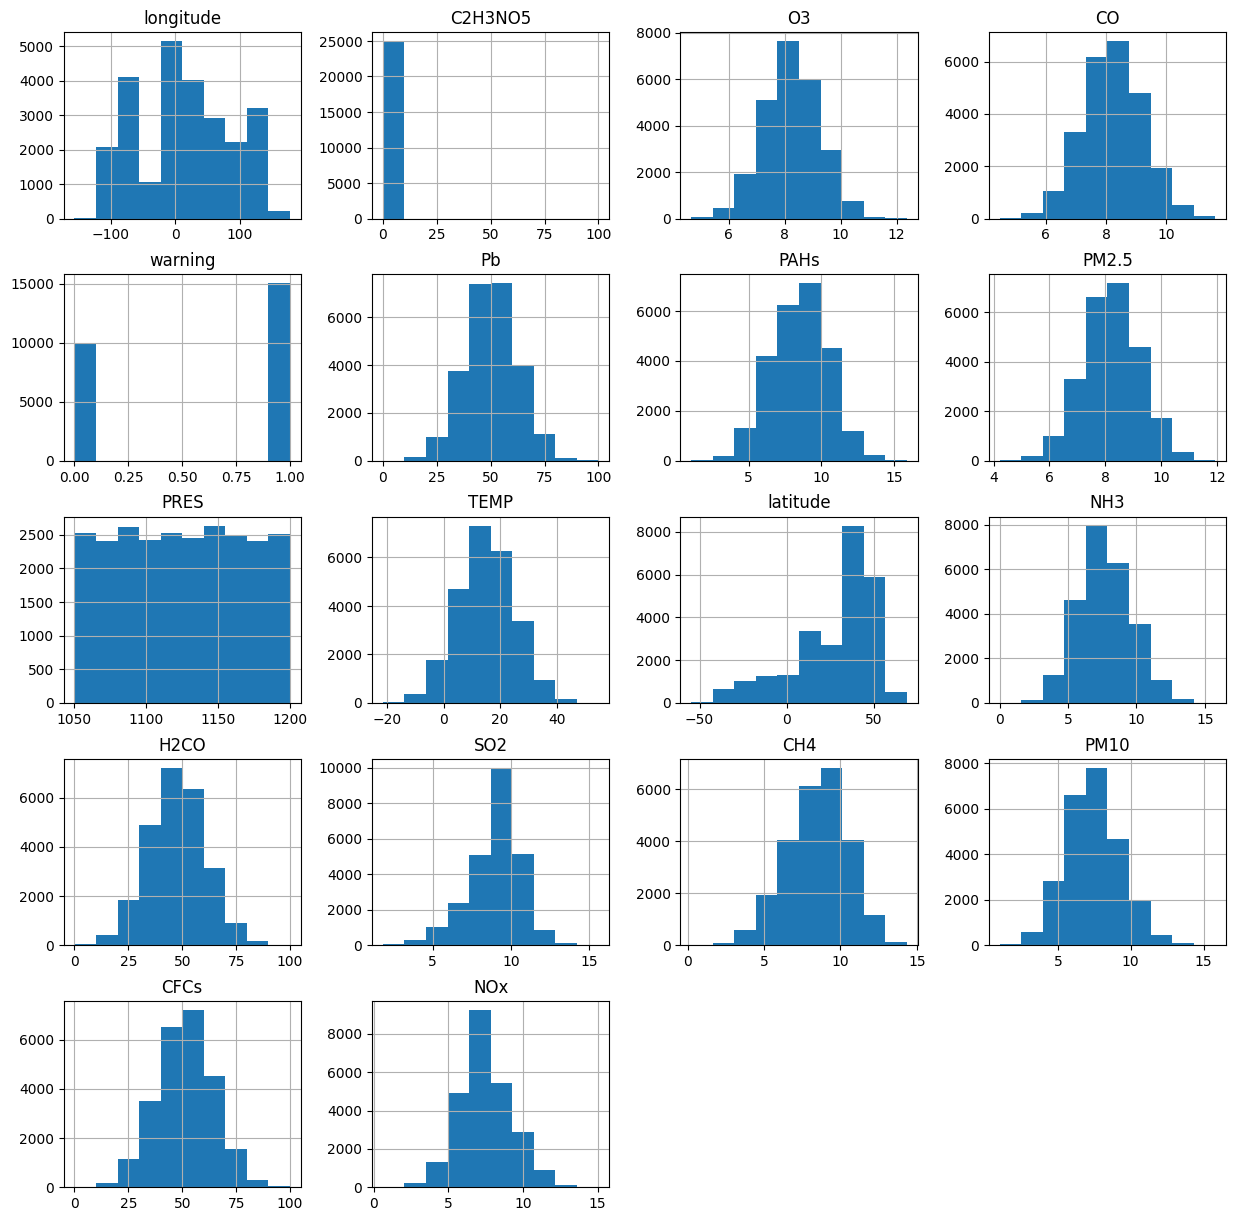

In [256]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)

In [257]:
def replace_outlier(merged, column_name):
    data = merged.copy(deep = True)
    perc_95 = data[column_name].quantile(.95)
    mean = data[column_name].mean()
    data.loc[data[column_name] > perc_95, column_name] = mean 
    return data


In [258]:
columns= ['C2H3NO5','O3','CO', 'Pb', 'PAHs', 'PM2.5','PRES','TEMP','NH3', 'H2CO' ,'SO2', 'CH4','PM10', 'CFCs','NOx']
for column_name in columns:
    merged = replace_outlier(merged, column_name)


C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>],
       [<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'Pb'}>,
        <AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'NH3'}>],
       [<AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

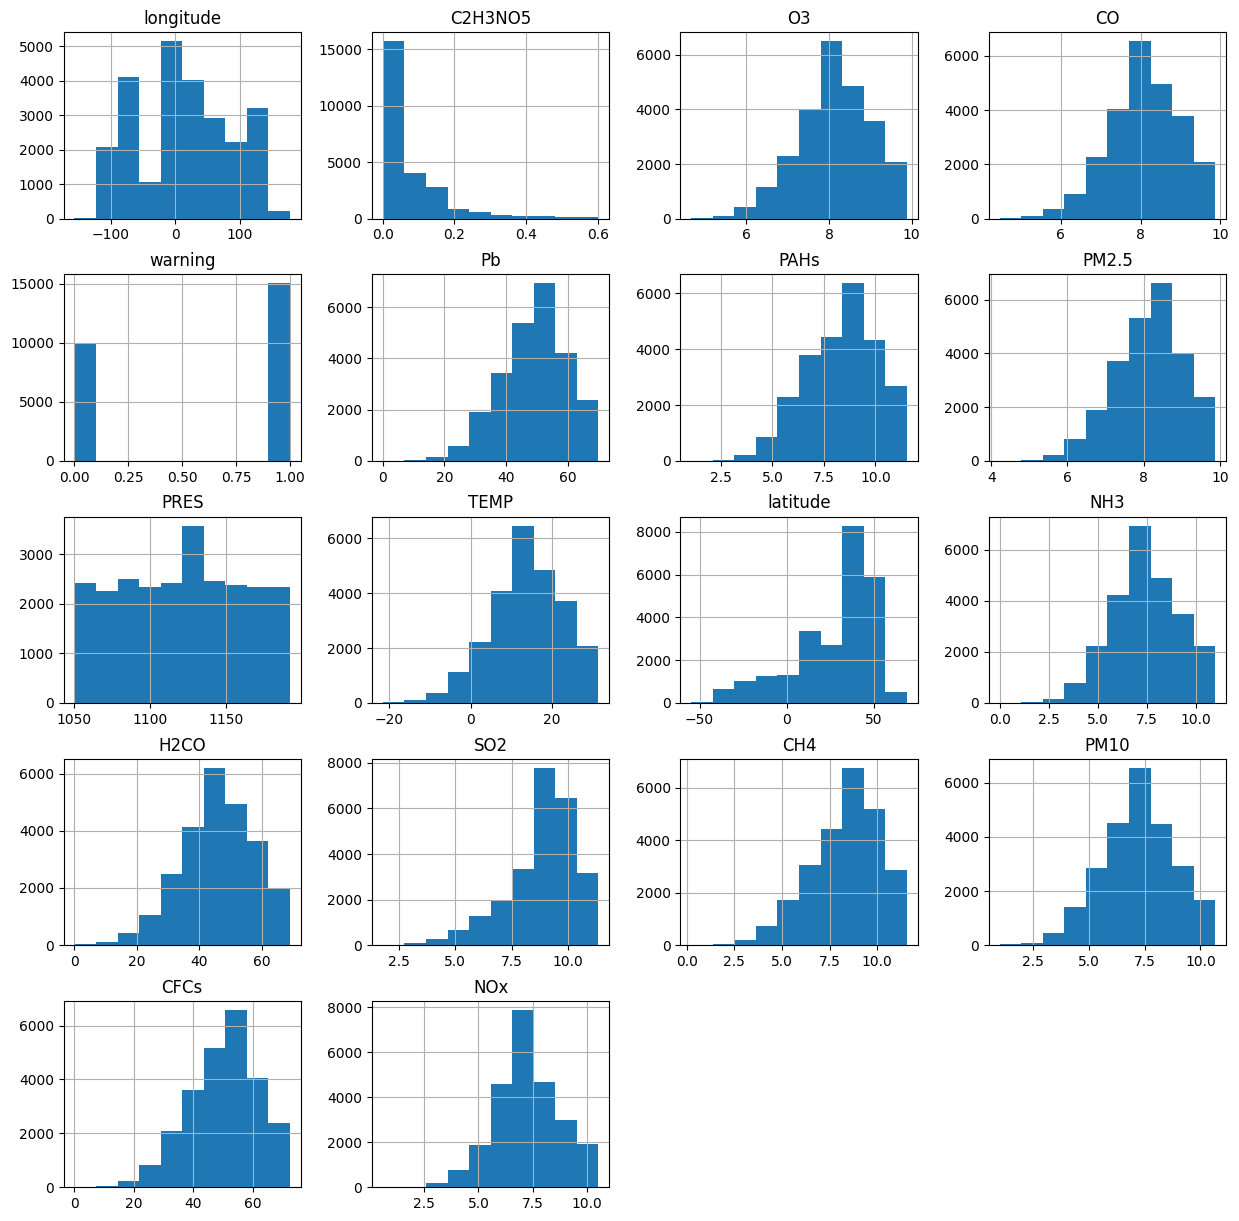

In [259]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)

Keďže našou úlohou bolo vyskúšať dve metódy na vysporiadanie sa s outliermi, horný kvantil sme sa rozhodli nahradiť hraničnými hodnotami. 

In [260]:
def remove_outlier(merged, column_name):
    data = merged.copy(deep = True)
    perc_05 = data[column_name].quantile(.05)
    data.loc[data[column_name] > perc_05, column_name]
    return data

In [261]:
columns= ['C2H3NO5','O3','CO', 'Pb', 'PAHs', 'PM2.5','PRES','TEMP','NH3', 'H2CO' ,'SO2', 'CH4','PM10', 'CFCs','NOx']
for column_name in columns:
    merged = remove_outlier(merged, column_name)

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\353805822.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  merged.hist(ax = ax)


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>],
       [<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'Pb'}>,
        <AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'NH3'}>],
       [<AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

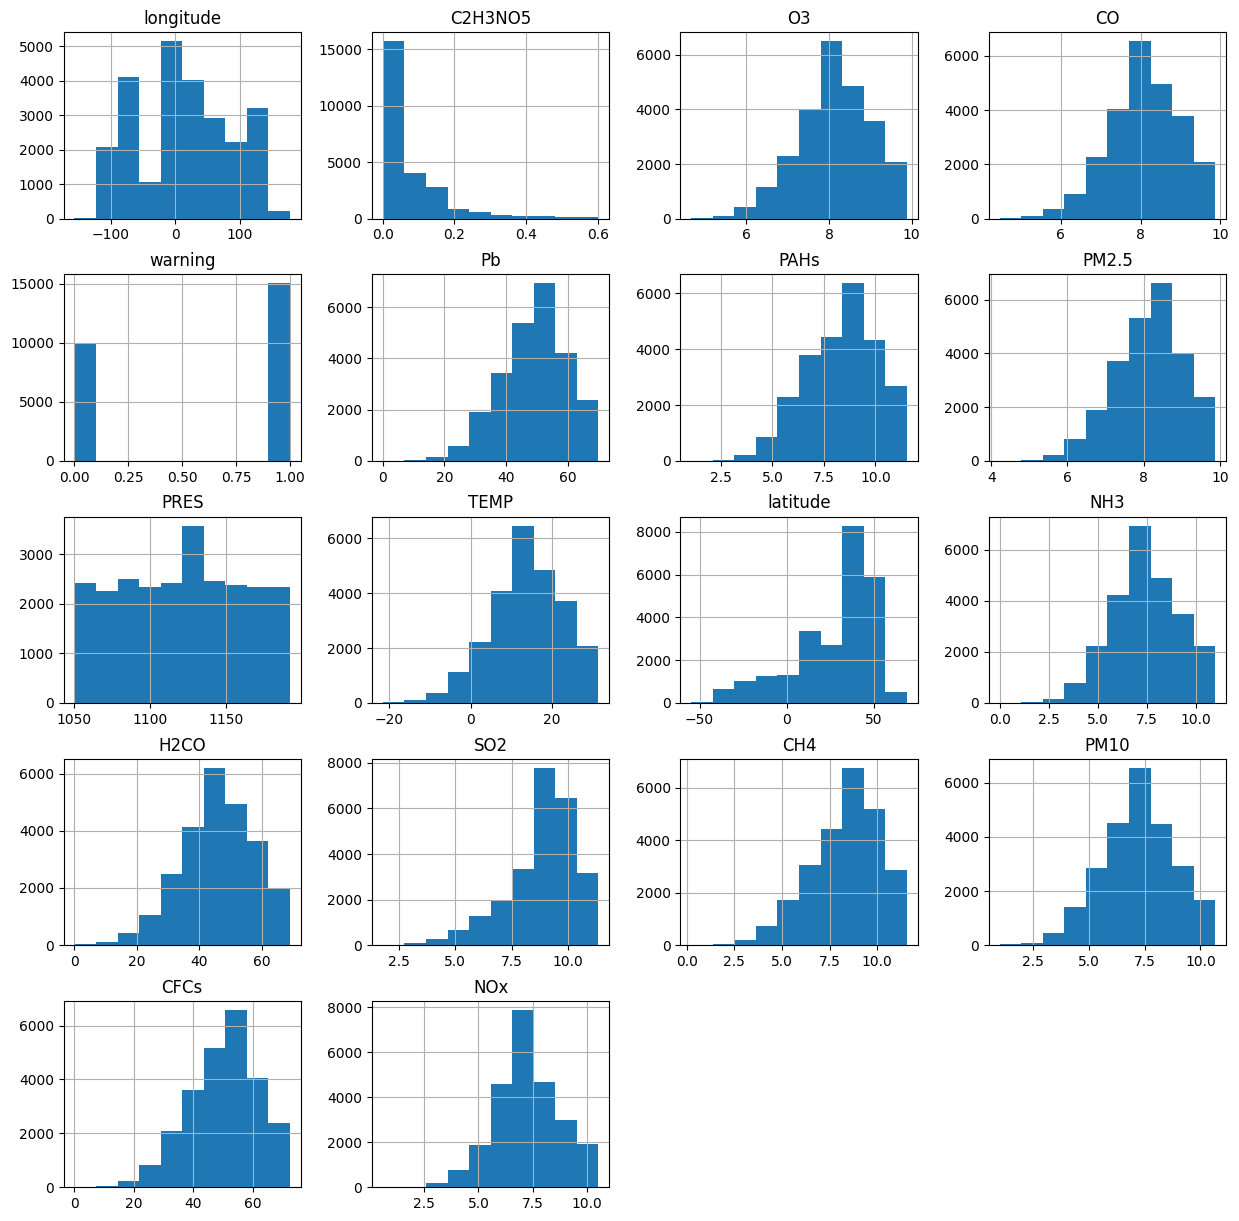

In [262]:
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
merged.hist(ax = ax)

## 2. realizácia predspracovania dát

Najskôr bolo potrebné rozdeliť dataset na testovaciu a trénovaciu časť

In [263]:
len(merged)

24983

Dáta sme sa rozhodli rozdeliť tak, že 20% dát budú tvoriť testovacie dáta a 80% trénovacie dáta.

In [264]:
train_data, test_data = train_test_split(merged, test_size=0.2)
print('Trénovacie dáta: '+ str(len(train_data))+' záznamov\n'+'Testovacie dáta: '+  str(len(test_data))+' záznamov')

Trénovacie dáta: 19986 záznamov
Testovacie dáta: 4997 záznamov


Podľa výsledkov z histogramov jednotlivých dát sme dáta zaradili do nasledovných rozdeliení.

In [265]:
skewed=['C2H3NO5', 'SO2', 'CH4']
transformed_atributes=['warning','PRES']
gaussian=['O3','CO','Pb', 'PAHs', 'PM2.5', 'TEMP', 'NH3', 'H2CO', 'PM10', 'CFCs', 'NOx']

Na základe histogramov atribútov skewed vidíme, že majú nepravidelne rozdielné hodnoty, v kvantiloch. Rozhodli sme sa ich transformovať quantilovým transformerom.

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\839527985.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[skewed].hist(ax = ax)


array([[<AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'SO2'}>],
       [<AxesSubplot: title={'center': 'CH4'}>, <AxesSubplot: >]],
      dtype=object)

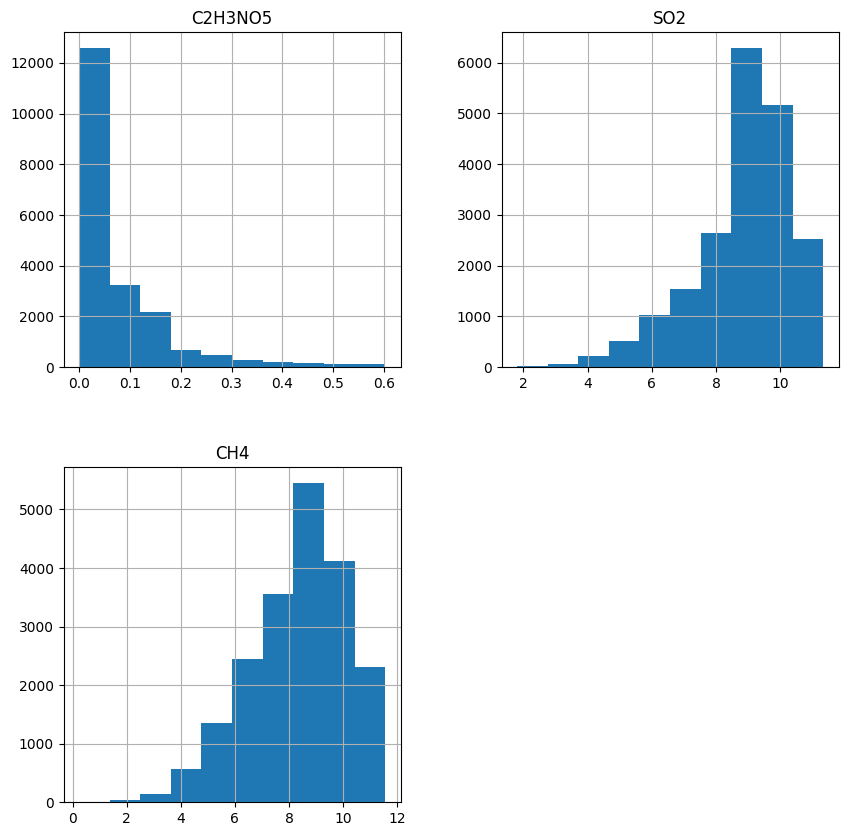

In [266]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca()
train_data[skewed].hist(ax = ax)

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\1037097572.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[skewed].hist(ax = ax)


array([[<AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'SO2'}>],
       [<AxesSubplot: title={'center': 'CH4'}>, <AxesSubplot: >]],
      dtype=object)

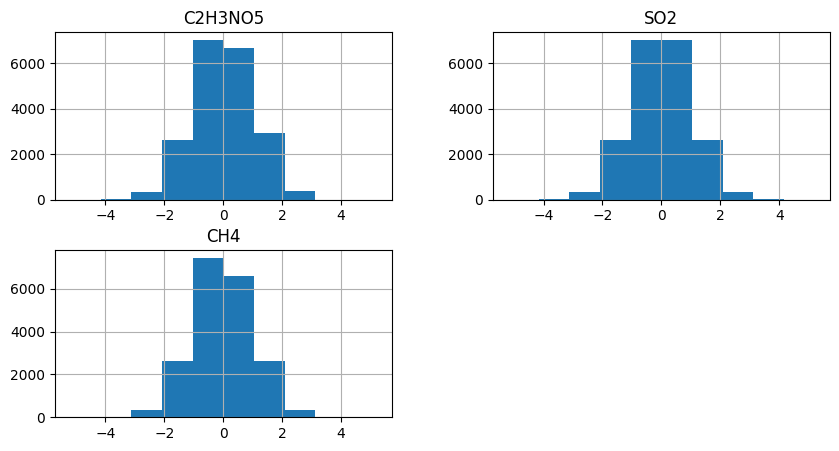

In [267]:
quantily = QuantileTransformer(output_distribution="normal",n_quantiles=1000)
train_data[skewed] = quantily.fit_transform(train_data[skewed])

fig = plt.figure(figsize = (10,5))
ax = fig.gca()
train_data[skewed].hist(ax = ax)

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\99330787.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[transformed_atributes].hist(ax = ax)


array([[<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'PRES'}>]], dtype=object)

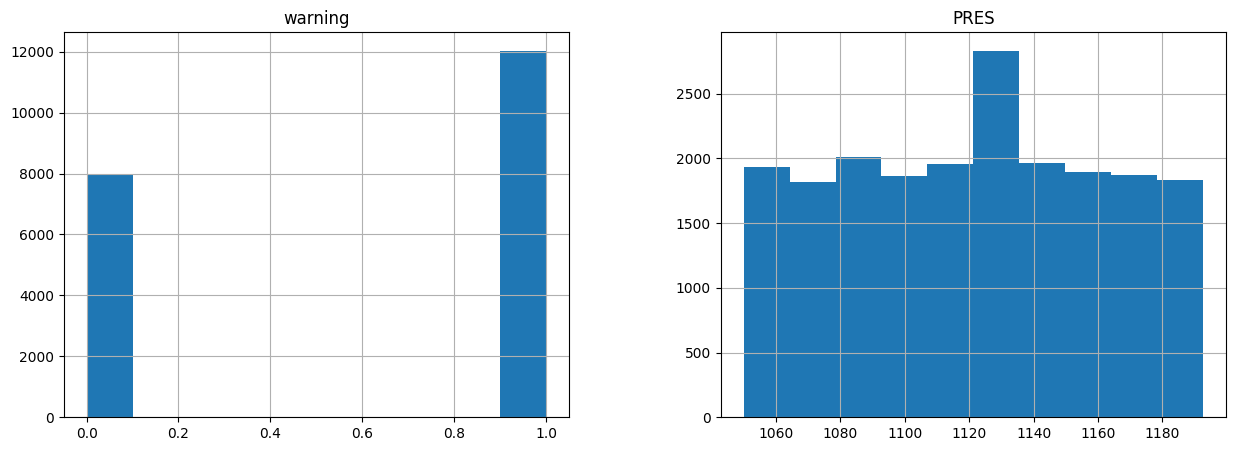

In [268]:
fig = plt.figure(figsize = (15,5))
ax = fig.gca()
train_data[transformed_atributes].hist(ax = ax)

Na atribúty napodobňujúce gaussovu krivku sme sa pokúsili použiť poweer transformation s metódou Yeo-Johnson. Pretože hodnoty v týchto stĺpcoch neboli úplne symetricky rozdelené.

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\4084925039.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[gaussian].hist(ax = ax)


array([[<AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'Pb'}>],
       [<AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'TEMP'}>],
       [<AxesSubplot: title={'center': 'NH3'}>,
        <AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >]],
      dtype=object)

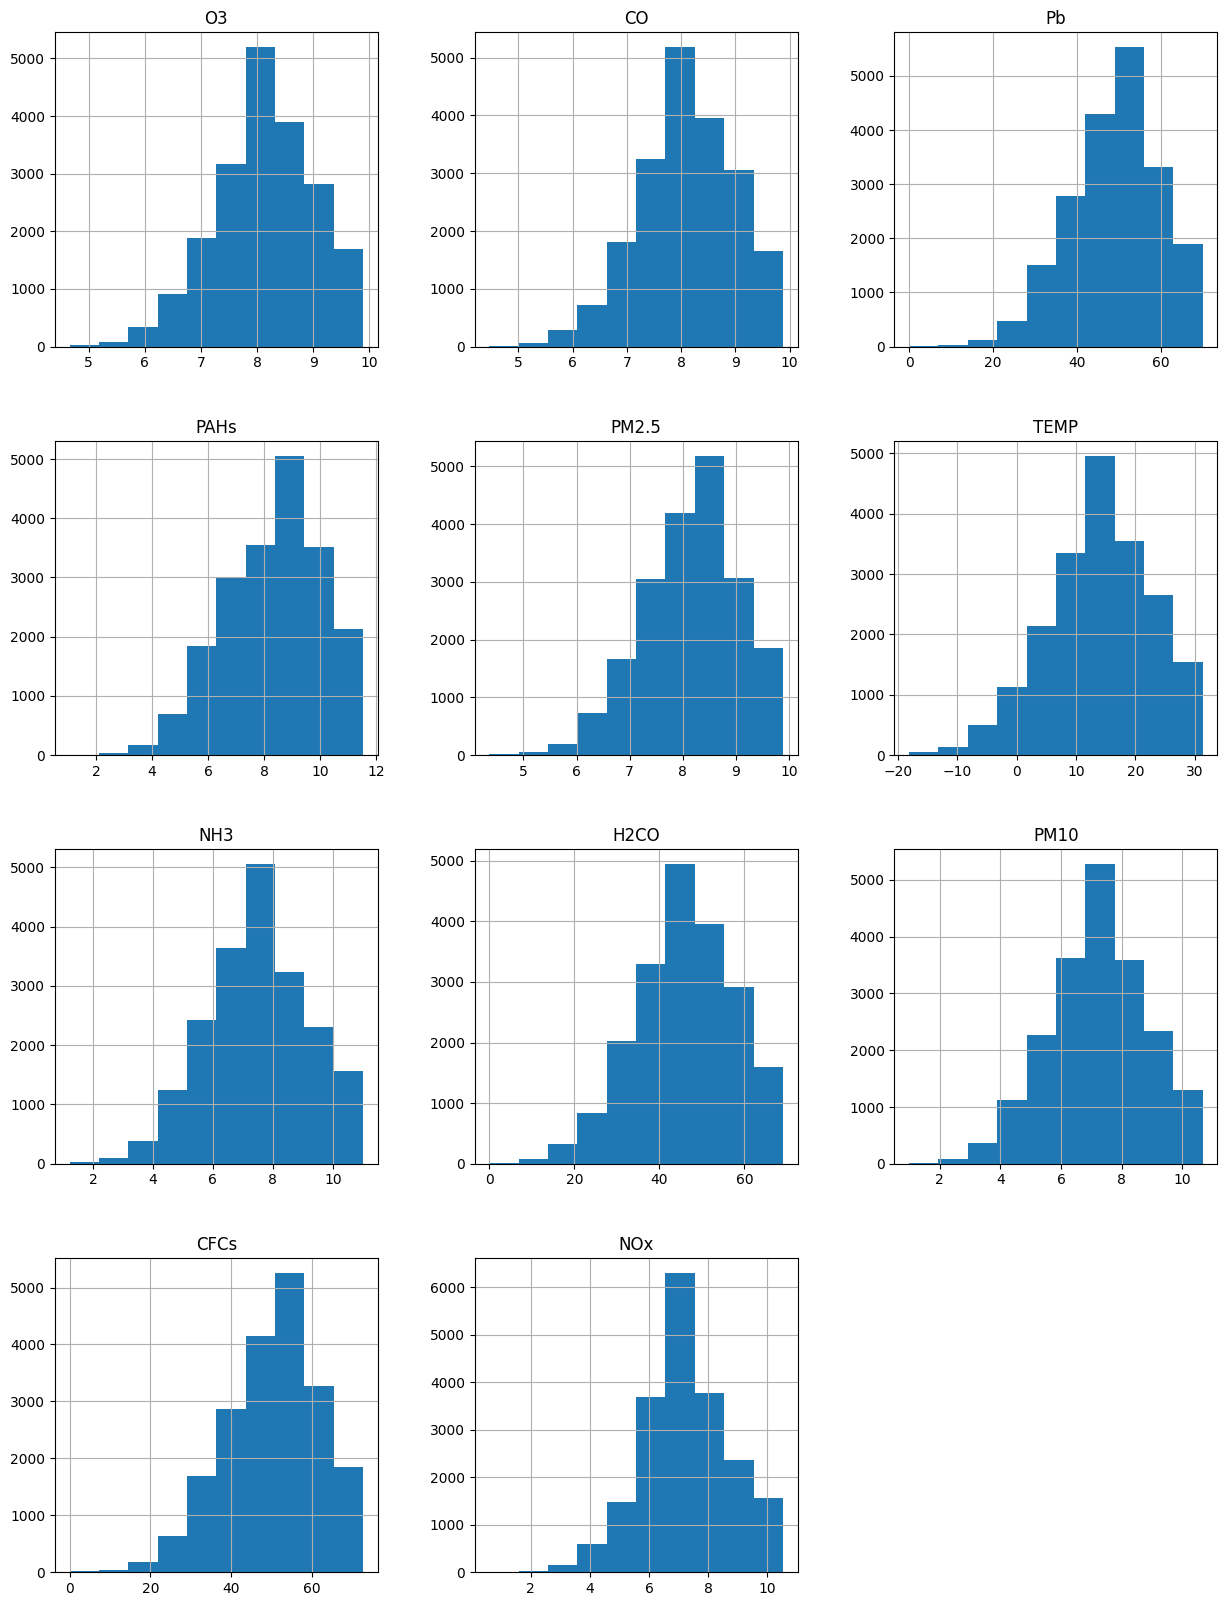

In [269]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[gaussian].hist(ax = ax)

In [270]:
power = PowerTransformer(method='yeo-johnson', standardize=True) 
train_data[gaussian] = power.fit_transform(train_data[gaussian])

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\4084925039.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data[gaussian].hist(ax = ax)


array([[<AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>,
        <AxesSubplot: title={'center': 'Pb'}>],
       [<AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>,
        <AxesSubplot: title={'center': 'TEMP'}>],
       [<AxesSubplot: title={'center': 'NH3'}>,
        <AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >]],
      dtype=object)

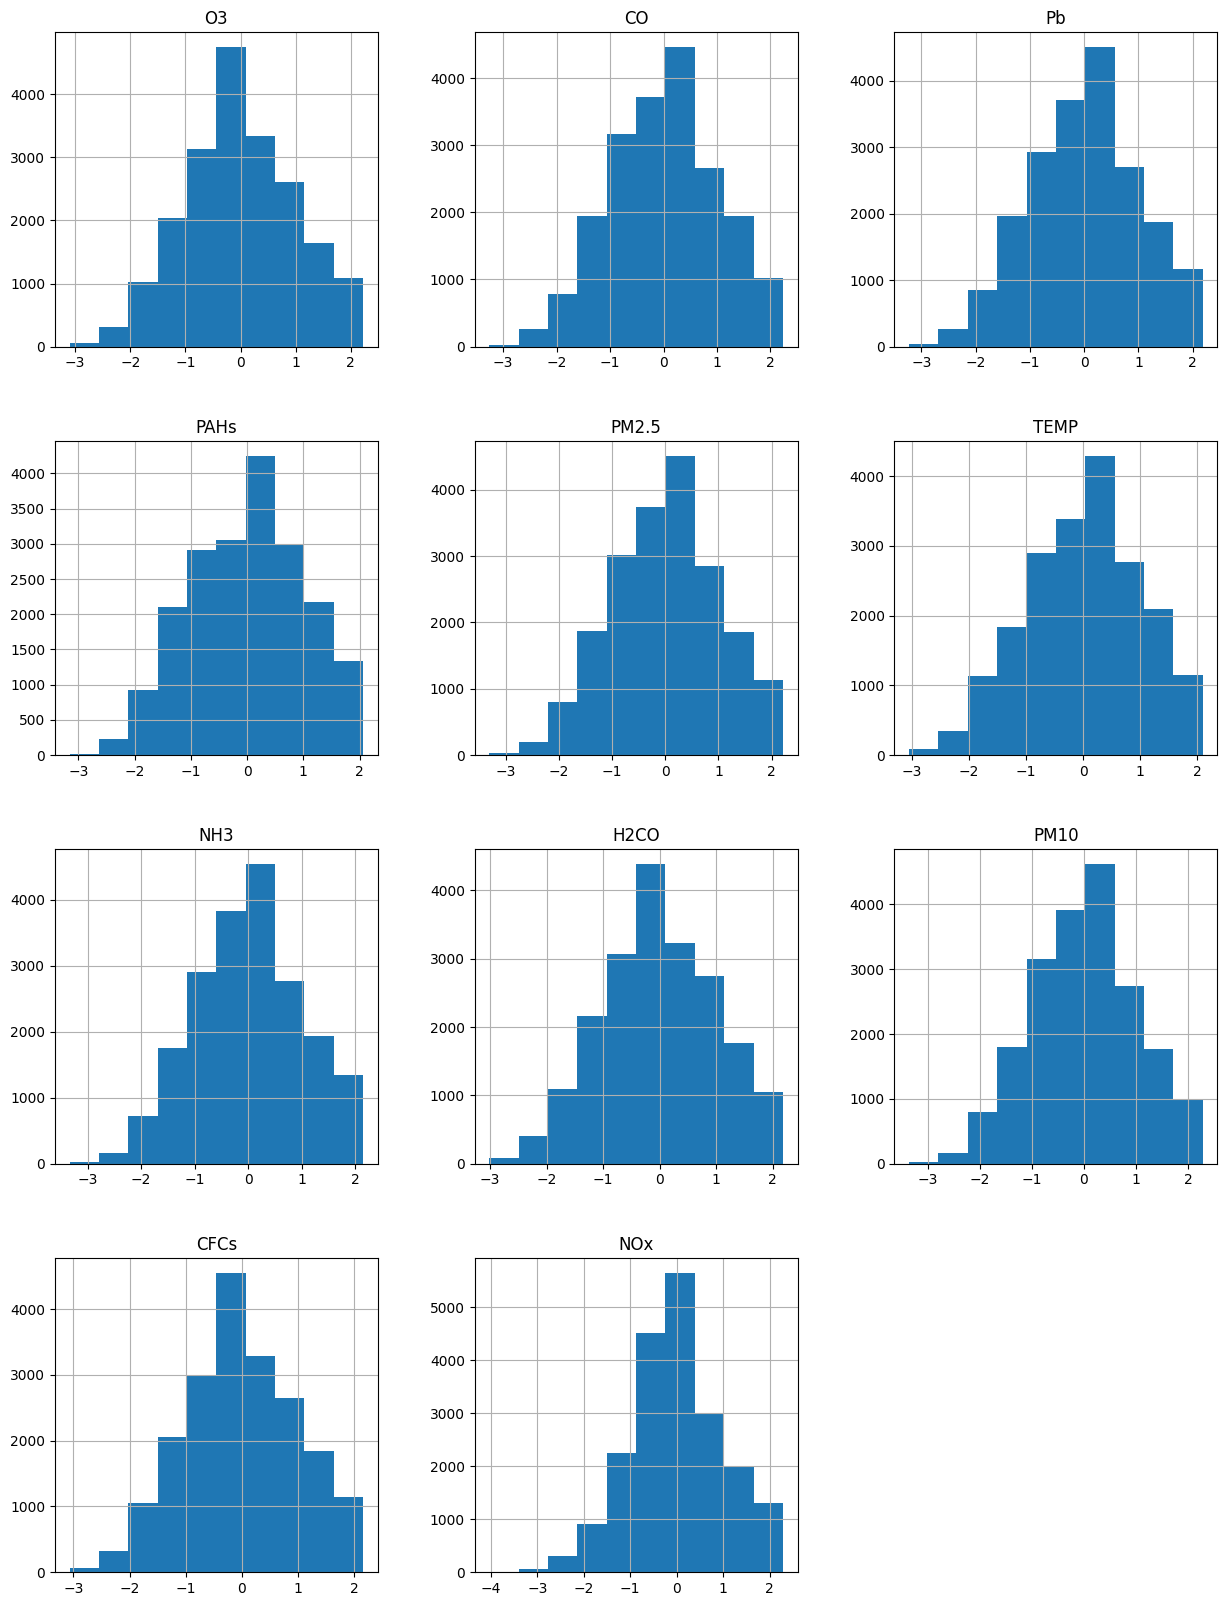

In [271]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data[gaussian].hist(ax = ax)

Na to aby sme dokončili normalizáciu údajov sme potrebovali použiť StandardScaler na nekategorické atribúty.

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\3602080221.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  train_data.hist(ax = ax)


array([[<AxesSubplot: title={'center': 'longitude'}>,
        <AxesSubplot: title={'center': 'C2H3NO5'}>,
        <AxesSubplot: title={'center': 'O3'}>,
        <AxesSubplot: title={'center': 'CO'}>],
       [<AxesSubplot: title={'center': 'warning'}>,
        <AxesSubplot: title={'center': 'Pb'}>,
        <AxesSubplot: title={'center': 'PAHs'}>,
        <AxesSubplot: title={'center': 'PM2.5'}>],
       [<AxesSubplot: title={'center': 'PRES'}>,
        <AxesSubplot: title={'center': 'TEMP'}>,
        <AxesSubplot: title={'center': 'latitude'}>,
        <AxesSubplot: title={'center': 'NH3'}>],
       [<AxesSubplot: title={'center': 'H2CO'}>,
        <AxesSubplot: title={'center': 'SO2'}>,
        <AxesSubplot: title={'center': 'CH4'}>,
        <AxesSubplot: title={'center': 'PM10'}>],
       [<AxesSubplot: title={'center': 'CFCs'}>,
        <AxesSubplot: title={'center': 'NOx'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

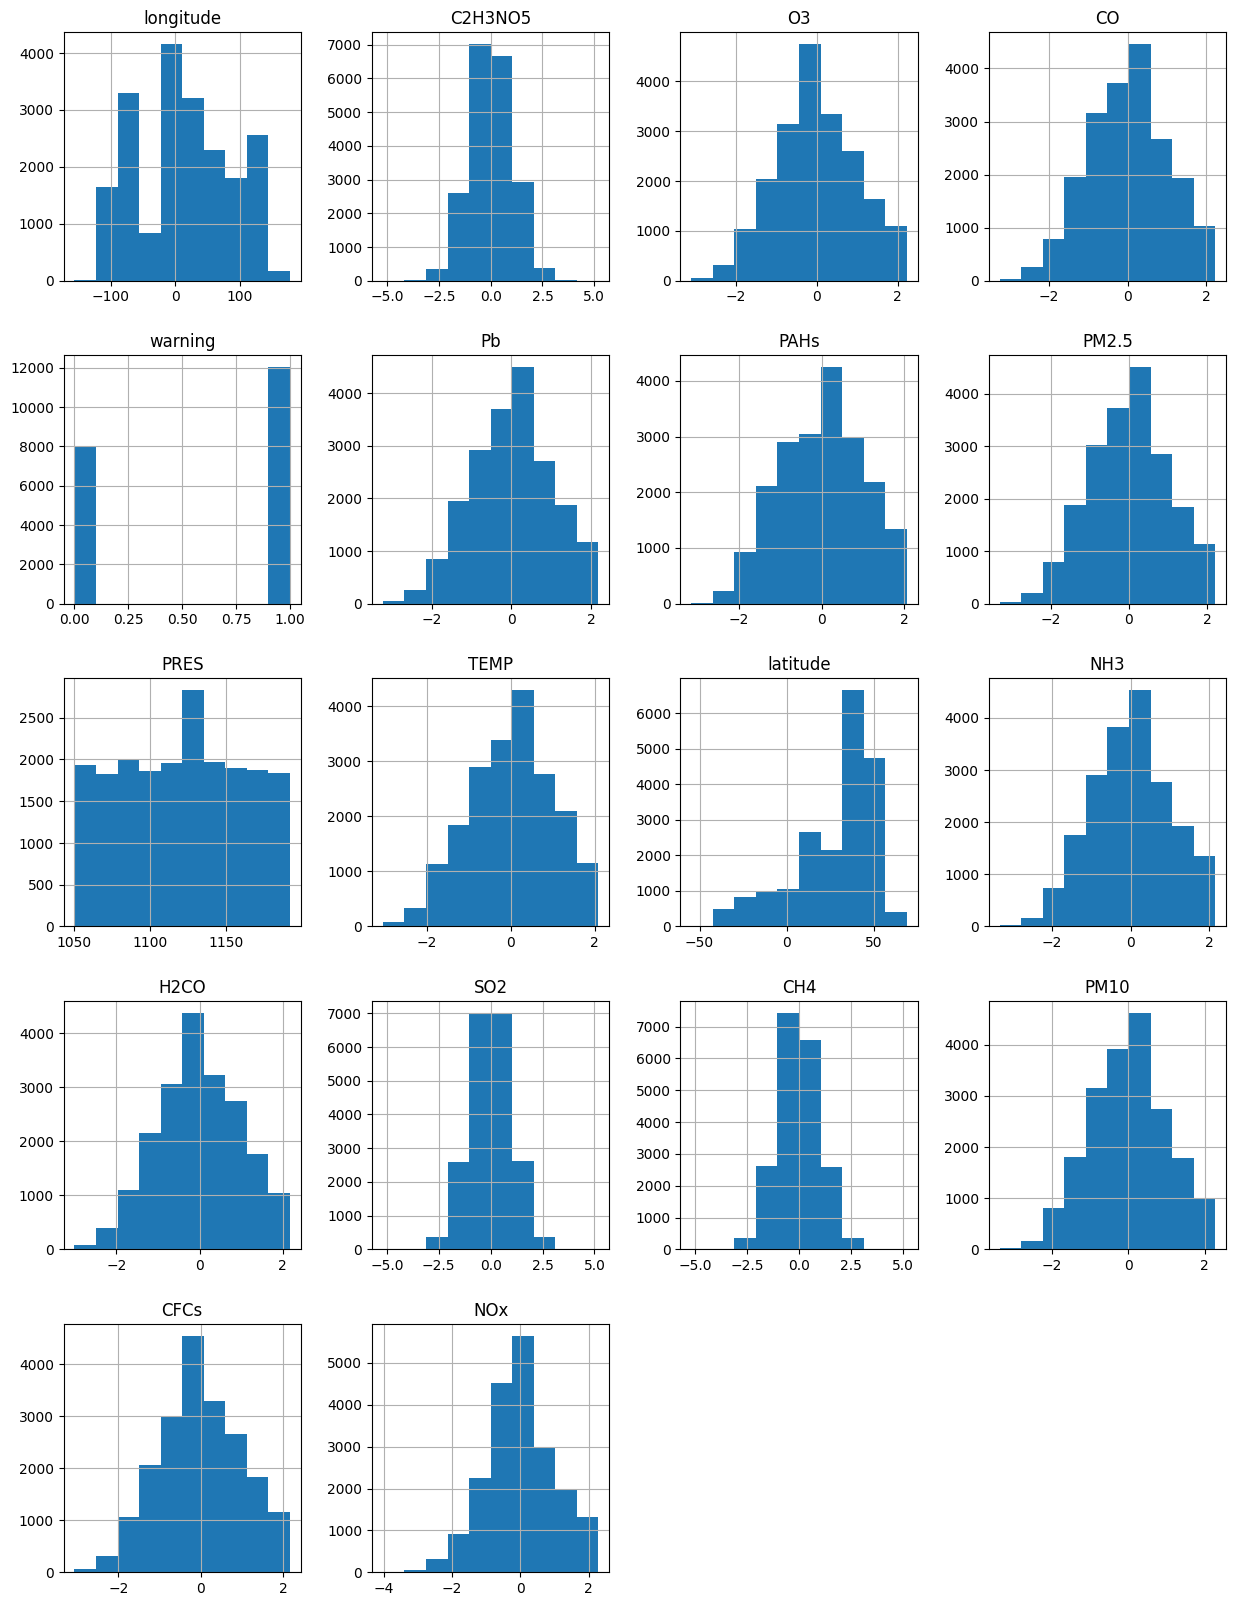

In [272]:
standard_scaler = StandardScaler()
train_data[gaussian + skewed] = standard_scaler.fit_transform(train_data[gaussian + skewed])

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train_data.hist(ax = ax)

## 3. Výber atribútov pre strojové účenie

Na to aby sme si vedeli správne vybrať atribúty na strojové učenie, budeme vychádzať z heat mapy, na ktorej je vidno korelácia jednotlivých atribútov k atribútu warning.

C:\Users\mxsit\AppData\Local\Temp\ipykernel_16156\1285704021.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(),ax=ax, annot =True, fmt = ".3f")


<AxesSubplot: >

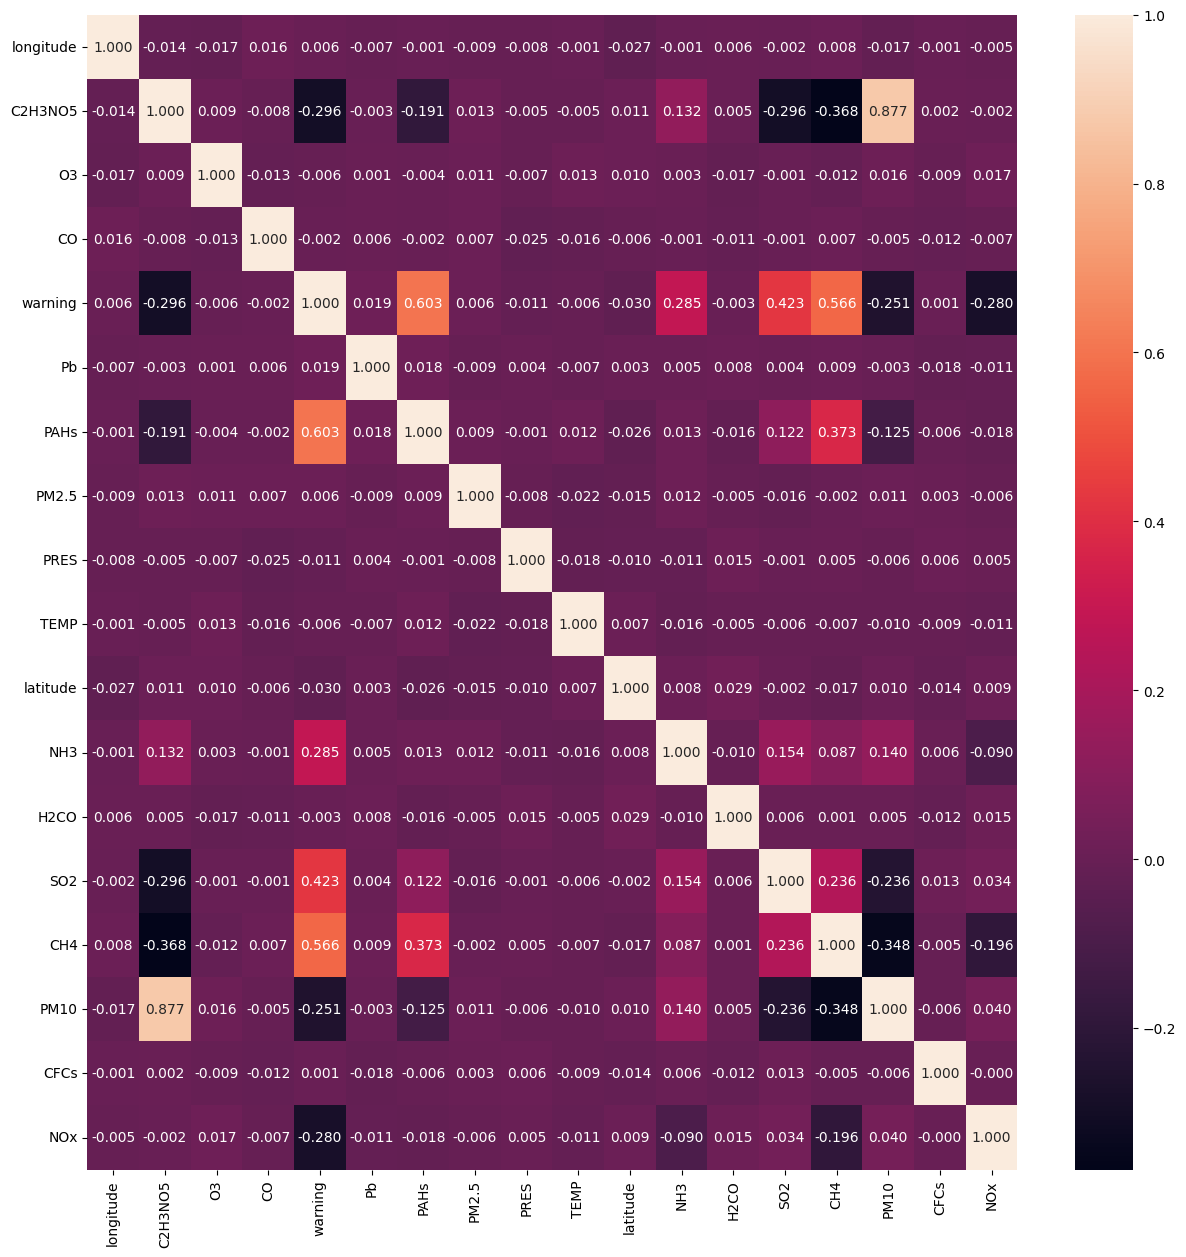

In [273]:
figure, ax = plt.subplots(figsize=(15,15))
sns.heatmap(train_data.corr(),ax=ax, annot =True, fmt = ".3f")

In [274]:
train_data.dtypes

longitude    float64
C2H3NO5      float64
O3           float64
CO           float64
warning      float64
Pb           float64
PAHs         float64
PM2.5        float64
PRES         float64
TEMP         float64
latitude     float64
NH3          float64
H2CO         float64
SO2          float64
CH4          float64
PM10         float64
CFCs         float64
NOx          float64
station       object
revision      object
QoS           object
code          object
dtype: object

Na zisťovanie korelácie potrebujeme len číselné dáta, preto sme sa rozhodli všetky ostatné nebrať v úvahu.

In [275]:
num_data = train_data.select_dtypes([np.number])
num_data.dtypes.unique()

array([dtype('float64')], dtype=object)

Vypíšeme si korelácie atribútov na atribút warning zostupne:

In [276]:
attr_correlations = abs(num_data.corr()["warning"])
print(attr_correlations.sort_values(ascending=False))

warning      1.000000
PAHs         0.602557
CH4          0.565716
SO2          0.423294
C2H3NO5      0.296154
NH3          0.285099
NOx          0.279950
PM10         0.250826
latitude     0.029945
Pb           0.018566
PRES         0.010689
PM2.5        0.006325
TEMP         0.006321
longitude    0.005830
O3           0.005660
H2CO         0.002720
CO           0.001593
CFCs         0.001150
Name: warning, dtype: float64


Z výsledku vyplýva, že v našom datasete je viacero atribútov, ktoré majú zvýšenú koreláciu na atribút warning.

<AxesSubplot: >

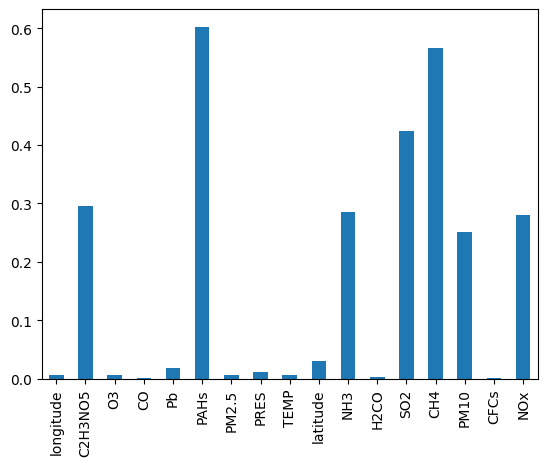

In [277]:
attr_correlations.drop('warning').plot(kind='bar')

## 4. Replikovateľnosť a predspracovanie

In [278]:
def find_index(arr, data):
    my_list = list()
    for element in arr:
        if element in data:
            my_list.append(data.columns.get_loc(element))
    return my_list

In [279]:
#quantily = QuantileTransformer(output_distribution="normal", random_state=1, n_quantiles=1000)
qt = make_column_transformer((quantily, find_index(skewed, num_data)), remainder = "passthrough")
pt = make_column_transformer((power, find_index(gaussian, num_data)), remainder = "passthrough")
sc = make_column_transformer((standard_scaler, find_index(gaussian + skewed, num_data)), remainder = "passthrough")

In [281]:
my_pipe = Pipeline(steps = [("quantile", qt),
                            ("power", pt),
                            ("scaler", sc),
                           ])

In [282]:
test = my_pipe.fit_transform(num_data)
pd.DataFrame(test, columns = num_data.columns) # krajsi vypis

,longitude,C2H3NO5,O3,CO,warning,Pb,PAHs,PM2.5,PRES,TEMP,latitude,NH3,H2CO,SO2,CH4,PM10,CFCs,NOx
0,-0.272727,0.812723,0.151667,-0.714525,0.566427,-1.067991,-2.004744,0.051483,0.399395,-0.379390,-0.916311,-1.283499,1.331752,0.825972,2.077828,-0.319352,-1.516869,1.686831
1,0.600016,0.812723,0.187826,-1.261075,0.767578,0.988229,0.061778,1.417128,-0.836678,-0.157333,0.022389,0.286289,-0.291805,-0.380490,0.488958,0.055549,-0.338430,-1.909106
2,1.328683,-1.230432,-0.884534,-1.372362,0.561689,0.487356,0.335716,0.286262,1.510308,-0.340652,-0.718845,-1.347860,-1.089662,-0.762086,-0.563092,0.948975,0.220150,1.590389
3,0.056970,-1.230432,1.515866,0.866987,0.369331,-0.336501,-0.966147,2.590770,-0.486112,-0.412213,-0.235917,-1.221679,1.572308,0.236678,1.619540,0.055549,-1.467341,-1.520527
4,-1.576761,-1.230432,-1.040649,0.056914,-1.747883,1.550255,1.810367,-2.086399,1.225042,-0.193651,0.601492,-0.746891,-0.527124,-0.518162,-0.538405,-0.483128,1.829432,-0.732921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19981,-0.709045,0.812723,-0.798056,0.089562,0.584144,-2.122205,0.968484,0.537806,1.114197,0.372696,-0.091317,0.085375,-1.763201,0.726818,-0.463028,0.901757,1.309847,-0.342551
19982,1.617207,-1.230432,0.924627,-0.186326,-1.865623,1.397109,0.828286,-0.596789,0.788175,-1.354798,1.837150,0.124061,0.051192,-0.414201,-1.102507,-0.440448,1.111568,-0.472231
19983,-1.266473,0.812723,-0.628845,0.334755,0.987561,1.203360,0.021140,0.709764,1.138906,0.133867,-0.822057,-0.137924,-1.129954,0.052670,-0.500361,1.109224,0.168522,1.489517
19984,0.336640,0.812723,0.287786,0.687718,-0.227054,-0.269254,-0.160930,0.167408,-0.842917,2.043953,-0.128926,0.781457,1.022468,0.396460,1.664273,-0.246197,-0.104160,-0.500137
